## Imports

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## Dataset

In [35]:
ds = tfds.load("colorectal_histology", download=True)

In [36]:
ds_tr = list(tfds.as_numpy(ds)["train"])

In [37]:
ds_x = np.array([i['image'] for i in ds_tr])/255
ds_y = np.array([i['label'] for i in ds_tr])

In [38]:
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, shuffle=True)

## Dataset Normalization

In [39]:
def one_hot_encoding(y_data):
    y_data = y_data.astype(np.int8)
    y_zeros = np.zeros(shape=(y_data.shape[0], 8))
    y_zeros[np.arange(y_data.shape[0]), y_data] =  1
    return y_zeros

In [40]:
y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)
y_val = one_hot_encoding(y_val)

## Model 1(Без сжатия картинок)

In [13]:
inp_layer = tf.keras.layers.Input(shape=(150,150,3))
conv1 = tf.keras.layers.Conv2D(2**6, kernel_size=(3,3), padding="valid", activation="relu")(inp_layer)
max_p1 = tf.keras.layers.MaxPool2D()(conv1)
conv2 = tf.keras.layers.Conv2D(2**7, kernel_size=(3,3), padding="valid", activation="relu")(max_p1)
max_p2 = tf.keras.layers.MaxPool2D()(conv2)
conv3 = tf.keras.layers.Conv2D(2**8, kernel_size=(3,3), padding="valid", activation="relu")(max_p2)
max_p3 = tf.keras.layers.MaxPool2D()(conv3)
conv4 = tf.keras.layers.Conv2D(2**9, kernel_size=(3,3), padding="valid", activation="relu")(max_p3)
max_p4 = tf.keras.layers.MaxPool2D()(conv4)
fl = tf.keras.layers.Flatten()(max_p4)
out_layer = tf.keras.layers.Dense(8, activation="softmax")(fl)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="CategoricalCrossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=100, callbacks=[es])

Epoch 1/100
250/250 [==============================] - 135s 537ms/step - loss: 1.1939 - accuracy: 0.4947 - val_loss: 0.9114 - val_accuracy: 0.6237
Epoch 2/100
250/250 [==============================] - 133s 531ms/step - loss: 0.8307 - accuracy: 0.6580 - val_loss: 0.7777 - val_accuracy: 0.7262
Epoch 3/100
250/250 [==============================] - 134s 537ms/step - loss: 0.7063 - accuracy: 0.7312 - val_loss: 0.8254 - val_accuracy: 0.6875
Epoch 4/100
250/250 [==============================] - 131s 526ms/step - loss: 0.6705 - accuracy: 0.7435 - val_loss: 0.8281 - val_accuracy: 0.7100
Epoch 5/100
250/250 [==============================] - 133s 531ms/step - loss: 0.6441 - accuracy: 0.7545 - val_loss: 0.6626 - val_accuracy: 0.7600
Epoch 6/100
250/250 [==============================] - 139s 556ms/step - loss: 0.5706 - accuracy: 0.7875 - val_loss: 0.6481 - val_accuracy: 0.7425
Epoch 7/100
250/250 [==============================] - 141s 563ms/step - loss: 0.5542 - accuracy: 0.7897 - val_loss: 0

In [19]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 2s 219ms/step - loss: 0.5129 - accuracy: 0.8600


[0.5129444599151611, 0.8600000143051147]

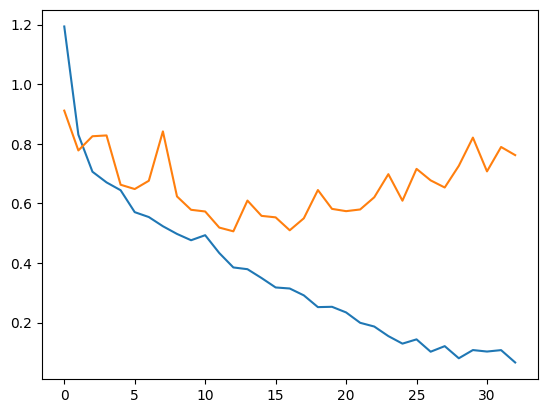

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

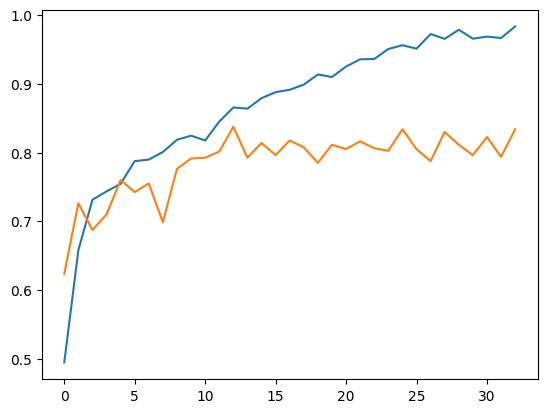

In [21]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

## Model 2(С сжатием картинок)

In [14]:
x_train_64 = np.array([cv2.resize(i, (64,64)) for i in x_train])
x_test_64 = np.array([cv2.resize(i, (64,64)) for i in x_test])
x_val_64 = np.array([cv2.resize(i, (64,64)) for i in x_val])

In [27]:
inp_layer = tf.keras.layers.Input(shape=(64,64,3))
conv1 = tf.keras.layers.Conv2D(2**6, kernel_size=(3,3), padding="valid", activation="relu")(inp_layer)
max_p1 = tf.keras.layers.MaxPool2D()(conv1)
conv2 = tf.keras.layers.Conv2D(2**7, kernel_size=(3,3), padding="valid", activation="relu")(max_p1)
max_p2 = tf.keras.layers.MaxPool2D()(conv2)
conv3 = tf.keras.layers.Conv2D(2**8, kernel_size=(3,3), padding="valid", activation="relu")(max_p2)
max_p3 = tf.keras.layers.MaxPool2D()(conv3)
conv4 = tf.keras.layers.Conv2D(2**9, kernel_size=(3,3), padding="valid", activation="relu")(max_p3)
max_p4 = tf.keras.layers.MaxPool2D()(conv4)
fl = tf.keras.layers.Flatten()(max_p4)
out_layer = tf.keras.layers.Dense(8, activation="softmax")(fl)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

In [28]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 256)       2951

In [29]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="CategoricalCrossentropy", metrics=["accuracy"])

In [30]:
history2 = model.fit(x_train_64, y_train, validation_data=(x_val_64, y_val), batch_size=32, epochs=50, callbacks=[es])

Epoch 1/50
125/125 [==============================] - 31s 242ms/step - loss: 1.5243 - accuracy: 0.3753 - val_loss: 1.1611 - val_accuracy: 0.4650
Epoch 2/50
125/125 [==============================] - 31s 244ms/step - loss: 0.9823 - accuracy: 0.6010 - val_loss: 0.9230 - val_accuracy: 0.6338
Epoch 3/50
125/125 [==============================] - 29s 235ms/step - loss: 0.8983 - accuracy: 0.6398 - val_loss: 0.9457 - val_accuracy: 0.5913
Epoch 4/50
125/125 [==============================] - 29s 236ms/step - loss: 0.8122 - accuracy: 0.6750 - val_loss: 0.9275 - val_accuracy: 0.6363
Epoch 5/50
125/125 [==============================] - 30s 236ms/step - loss: 0.7720 - accuracy: 0.6970 - val_loss: 0.8728 - val_accuracy: 0.6513
Epoch 6/50
125/125 [==============================] - 29s 235ms/step - loss: 0.7528 - accuracy: 0.7057 - val_loss: 0.8032 - val_accuracy: 0.6812
Epoch 7/50
125/125 [==============================] - 30s 238ms/step - loss: 0.7112 - accuracy: 0.7270 - val_loss: 0.7833 - val_ac

In [31]:
model.evaluate(x_test_64, y_test)

7/7 [==============================] - 1s 47ms/step - loss: 0.4914 - accuracy: 0.8300


[0.491372674703598, 0.8299999833106995]

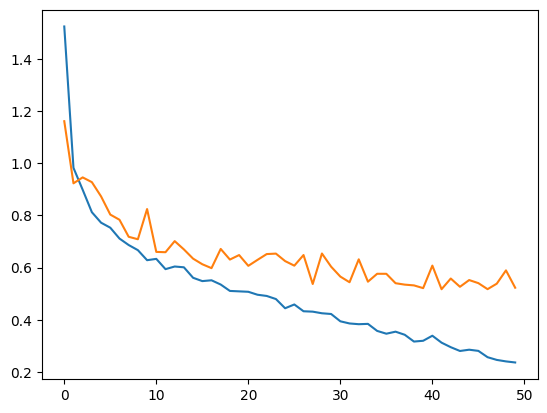

In [32]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])

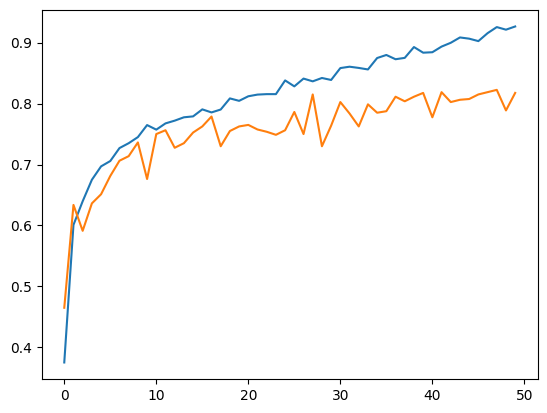

In [33]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])

## Model 3(dropout с исходным разрешением картинок)

In [48]:
inp_layer = tf.keras.layers.Input(shape=(150,150,3))
conv1 = tf.keras.layers.Conv2D(2**6, kernel_size=(3,3), padding="valid", activation="relu")(inp_layer)
max_p1 = tf.keras.layers.MaxPool2D()(conv1)
conv2 = tf.keras.layers.Conv2D(2**7, kernel_size=(3,3), padding="valid", activation="relu")(max_p1)
max_p2 = tf.keras.layers.MaxPool2D()(conv2)
conv3 = tf.keras.layers.Conv2D(2**8, kernel_size=(3,3), padding="valid", activation="relu")(max_p2)
max_p3 = tf.keras.layers.MaxPool2D()(conv3)
conv4 = tf.keras.layers.Conv2D(2**9, kernel_size=(3,3), padding="valid", activation="relu")(max_p3)
max_p4 = tf.keras.layers.MaxPool2D()(conv4)
fl = tf.keras.layers.Flatten()(max_p4)
drop = tf.keras.layers.Dropout(0,1)(fl)
out_layer = tf.keras.layers.Dense(8, activation="softmax")(drop)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

In [49]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 256)       2951

In [50]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="CategoricalCrossentropy", metrics=["accuracy"])

In [53]:
history3 = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=20, callbacks=[es])

Epoch 1/20
125/125 [==============================] - 137s 1s/step - loss: 1.0540 - accuracy: 0.5510 - val_loss: 0.8118 - val_accuracy: 0.6837
Epoch 2/20
125/125 [==============================] - 136s 1s/step - loss: 0.8429 - accuracy: 0.6690 - val_loss: 0.7542 - val_accuracy: 0.6687
Epoch 3/20
125/125 [==============================] - 138s 1s/step - loss: 0.7583 - accuracy: 0.7092 - val_loss: 0.6666 - val_accuracy: 0.7387
Epoch 4/20
125/125 [==============================] - 137s 1s/step - loss: 0.6933 - accuracy: 0.7452 - val_loss: 0.6830 - val_accuracy: 0.7163
Epoch 5/20
125/125 [==============================] - 139s 1s/step - loss: 0.6542 - accuracy: 0.7598 - val_loss: 0.5639 - val_accuracy: 0.7800
Epoch 6/20
125/125 [==============================] - 136s 1s/step - loss: 0.6374 - accuracy: 0.7697 - val_loss: 0.5876 - val_accuracy: 0.8000
Epoch 7/20
125/125 [==============================] - 144s 1s/step - loss: 0.6134 - accuracy: 0.7768 - val_loss: 0.5628 - val_accuracy: 0.7700

In [54]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 2s 287ms/step - loss: 0.4973 - accuracy: 0.8100


[0.4972997009754181, 0.8100000023841858]

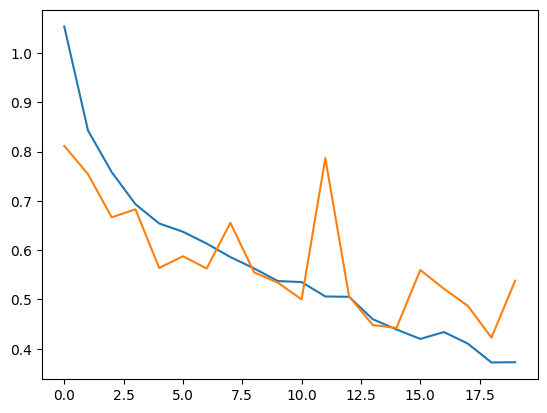

In [55]:
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])

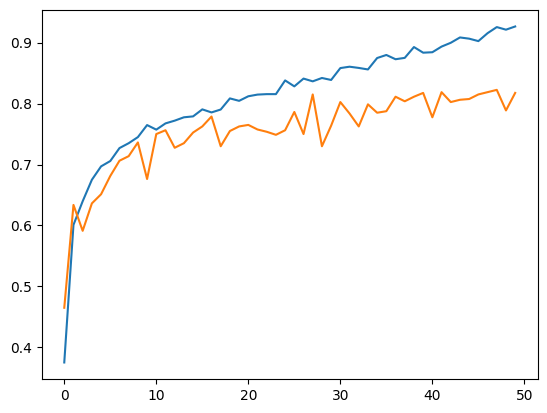

In [56]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])

## Model 4(dropout с сжатыми картинками)

In [65]:
inp_layer = tf.keras.layers.Input(shape=(64,64,3))
conv1 = tf.keras.layers.Conv2D(2**6, kernel_size=(3,3), padding="valid", activation="relu")(inp_layer)
max_p1 = tf.keras.layers.MaxPool2D()(conv1)
conv2 = tf.keras.layers.Conv2D(2**7, kernel_size=(3,3), padding="valid", activation="relu")(max_p1)
max_p2 = tf.keras.layers.MaxPool2D()(conv2)
conv3 = tf.keras.layers.Conv2D(2**8, kernel_size=(3,3), padding="valid", activation="relu")(max_p2)
max_p3 = tf.keras.layers.MaxPool2D()(conv3)
conv4 = tf.keras.layers.Conv2D(2**9, kernel_size=(3,3), padding="valid", activation="relu")(max_p3)
max_p4 = tf.keras.layers.MaxPool2D()(conv4)
fl = tf.keras.layers.Flatten()(max_p4)
drop = tf.keras.layers.Dropout(0,1)(fl)
out_layer = tf.keras.layers.Dense(8, activation="softmax")(drop)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

In [66]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 12, 256)       2951

In [69]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="CategoricalCrossentropy", metrics=["accuracy"])

In [70]:
history4 = model.fit(x_train_64, y_train, validation_data=(x_val_64, y_val), batch_size=16, epochs=20, callbacks=[es])

Epoch 1/20
250/250 [==============================] - 37s 147ms/step - loss: 2.0811 - accuracy: 0.1138 - val_loss: 2.0796 - val_accuracy: 0.1163
Epoch 2/20
250/250 [==============================] - 35s 138ms/step - loss: 2.0797 - accuracy: 0.1208 - val_loss: 2.0798 - val_accuracy: 0.1163
Epoch 3/20
250/250 [==============================] - 34s 135ms/step - loss: 2.0797 - accuracy: 0.1283 - val_loss: 2.0798 - val_accuracy: 0.1163
Epoch 4/20
250/250 [==============================] - 35s 139ms/step - loss: 2.0796 - accuracy: 0.1230 - val_loss: 2.0801 - val_accuracy: 0.1163
Epoch 5/20
250/250 [==============================] - 35s 139ms/step - loss: 2.0796 - accuracy: 0.1283 - val_loss: 2.0800 - val_accuracy: 0.1163
Epoch 6/20
250/250 [==============================] - 35s 142ms/step - loss: 2.0796 - accuracy: 0.1233 - val_loss: 2.0800 - val_accuracy: 0.1163
Epoch 7/20
250/250 [==============================] - 36s 143ms/step - loss: 2.0796 - accuracy: 0.1213 - val_loss: 2.0800 - val_ac

In [71]:
model.evaluate(x_test_64, y_test)

7/7 [==============================] - 0s 36ms/step - loss: 2.0811 - accuracy: 0.0950


[2.0811045169830322, 0.0949999988079071]

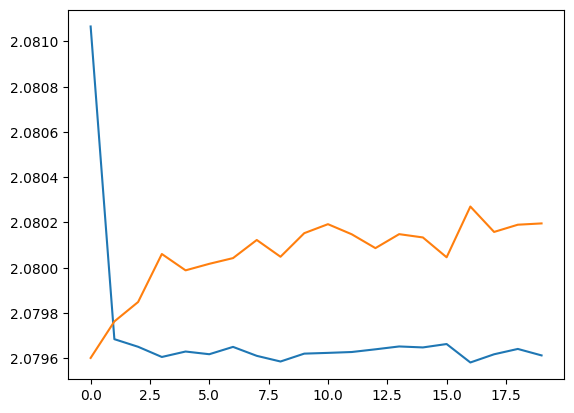

In [72]:
plt.plot(history4.history["loss"])
plt.plot(history4.history["val_loss"])

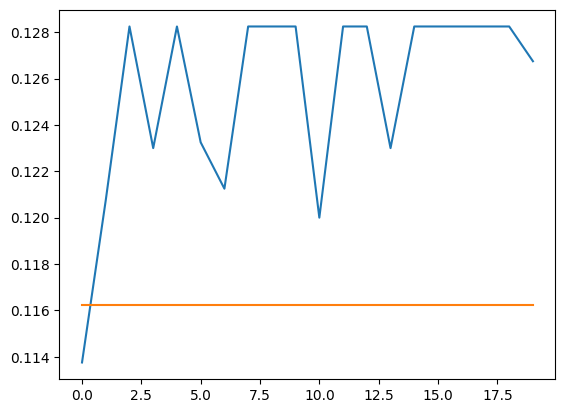

In [73]:
plt.plot(history4.history["accuracy"])
plt.plot(history4.history["val_accuracy"])